### Notebook Overview: Model Step 5 – Subnetwork Visualisation

This notebook visualises the results of the preceding analysis by generating clear, interpretable visual representations of each illicit subnetwork. It represents the fifth and final stage of the AML detection pipeline and translates the analytical outputs—classification, subnetwork construction, and node ranking—into forms that support investigative interpretation and decision-making.  

**Purpose**  
The purpose of this notebook is to convert ranked subnetwork data into visual formats that highlight transaction relationships, key actors, and fund flows. The visualisations bridge the gap between data analysis and operational insight, providing investigators with an auditable, easy-to-understand view of the network structure and ranking outcomes.  

**Key Steps**  
- Import ranked subnetwork and transaction data from BigQuery.  
- Generate two complementary visual perspectives for each subnetwork:  
  - Transaction-to-Transaction (txn–txn): shows directed Bitcoin flows between individual transactions.  
  - Address-to-Address (addr–addr): aggregates transactions to show relationships between wallet addresses.  
- Apply node ranking metrics to control visual prominence (e.g., node size, colour, and ordering).  
- Produce tabular summaries of each subnetwork, including structural statistics and top-ranked nodes.  
- Export all figures and tables for inclusion in the thesis and for use in investigative applications.  

This step completes the end-to-end AML detection framework by presenting analytical results in visual and tabular formats suitable for review, reporting, and further exploration.  

**Context and Attribution**  
This notebook forms part of the technical work developed in support of the research thesis titled:  
_“Detection, Ranking and Visualisation of Money Laundering Networks on the Bitcoin Blockchain”_  
by Jennifer Payne (RMIT University).  

GitHub Repository: [https://github.com/majorpayne-2021/rmit_master_thesis](https://github.com/majorpayne-2021/rmit_master_thesis)  
Elliptic++ Dataset Source: [https://github.com/git-disl/EllipticPlusPlus](https://github.com/git-disl/EllipticPlusPlus)


In [ ]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# GCP libraries
from pandas_gbq import to_gbq # write pandas df to a GCP BigQuery table
import gcsfs
import importlib.util
import os
import inspect

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


--------------
##### Read in Txn Subnetwork Classes & Modules
--------------


In [ ]:
# Define bucket and file path
bucket_name = "thesis_classes"
file_name = "txn_subnetworks.py"
gcs_path = f"gs://{bucket_name}/{file_name}"

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Local filename to save the script temporarily
local_file = f"/tmp/{file_name}"

# Download the file from GCS to local storage
fs.get(gcs_path, local_file)

# Dynamically import the module
module_name = "txn_subnetworks"
spec = importlib.util.spec_from_file_location(module_name, local_file)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [ ]:
# Use inspect to get classes and functions
classes = [name for name, obj in inspect.getmembers(module, inspect.isclass)]

# Print results
print("Classes in module:")
for cls in classes:
    print(f"  - {cls}")


Classes in module:
  - Line2D
  - build_txn_subnetwork
  - combinations
  - defaultdict
  - reporting
  - visualise_subnetwork


In [ ]:
# Instantiate the classes
build_vis = module.visualise_subnetwork()
build_report = module.reporting()

--------------
##### Read in Datasets
--------------


In [ ]:
# Get subnetwork edges table
%%bigquery df_network_edges
select * from `extreme-torch-467913-m6.networks.network_edges_final`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_network_edges.head(1)

,merged_subnetwork_id,src_txn_id,dst_txn_id,min_src_hop,min_dst_hop
0,0,3084073,230658142,0,1


In [ ]:
# Get subnetwork rank table
%%bigquery df_txn_rank
select * from `extreme-torch-467913-m6.networks.network_txn_rank`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_txn_rank.head(1)

,merged_subnetwork_id,node,in_BTC_total,in_txs_degree,out_txs_degree,pagerank,pagerank_pct,pagerank_pct_filled_for_contrib,in_btc_pct,in_deg_pct,out_deg_pct,out_deg_pct_inv,in_btc_share,pr_weight,val_weight,in_weight,out_weight,pr_contrib,val_contrib,in_deg_contrib,out_deg_contrib,composite_raw,composite_pct,composite_rank,pagerank_missing,pr_rank,hub_score,authority_score,hub_rank,authority_rank,rank_inDeg,rank_outDeg,betweenness,harmonic,eigenvector,katz,coreness,rank_betw,rank_harm,rank_eig,rank_katz,rank_coreness,hop
0,27227,163867600,2.7220,1,0,0.0056,0.6503,0.6503,0.0055,0.5055,0.0055,0.9945,0.0037,0.6000,0.3000,0.0700,0.0300,0.3902,0.0016,0.0354,0.0298,0.4570,0.3443,121,False,1.0000,0.0000,-0.0083,93.0000,114.0000,1.0000,1.0000,0.0000,5.7840,0.0018,0.0740,1.0000,92.0000,1.0000,182.0000,1.0000,1.0000,182


In [ ]:
# Get address txn edgelist
%%bigquery df_addrtxn
select * from `extreme-torch-467913-m6.actor.addrtxn_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_addrtxn.head(1)

,input_address,txId
0,14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a,230325127


In [ ]:
# Get txn address edgelist
%%bigquery df_txnaddr
select * from `extreme-torch-467913-m6.actor.txaddr_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_txnaddr.head(1)

,txId,output_address
0,230325127,1GASxu5nMntiRKdVtTVRvEbP965G51bhHH


In [ ]:
# Get nw summary table
%%bigquery df_nw_summary
select * from `extreme-torch-467913-m6.networks.network_summary`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_nw_summary.head(1)

,merged_subnetwork_id,txn_ids,node_count,edge_count,depth,seeds,seed_count,linked_txn_count
0,17742,"[101586718, 130897027, 138779422, 162026612, 1...",394,438,15,"[130897027, 176149522, 298005149, 306112320, 3...",223,171


--------------
##### Build txn-txn subnetwork visualisation
--------------


In [ ]:
subnetwork_filter = 14247
df_nw_summary[df_nw_summary['merged_subnetwork_id']==subnetwork_filter]

,merged_subnetwork_id,txn_ids,node_count,edge_count,depth,seeds,seed_count,linked_txn_count
168,14247,"[254968704, 267235757, 267236707, 298391612, 3...",20,19,12,[363147427],1,19


ℹ️ Converted df_network_edges['merged_subnetwork_id'] to int64
ℹ️ Converted df_ranked['merged_subnetwork_id'] to int64


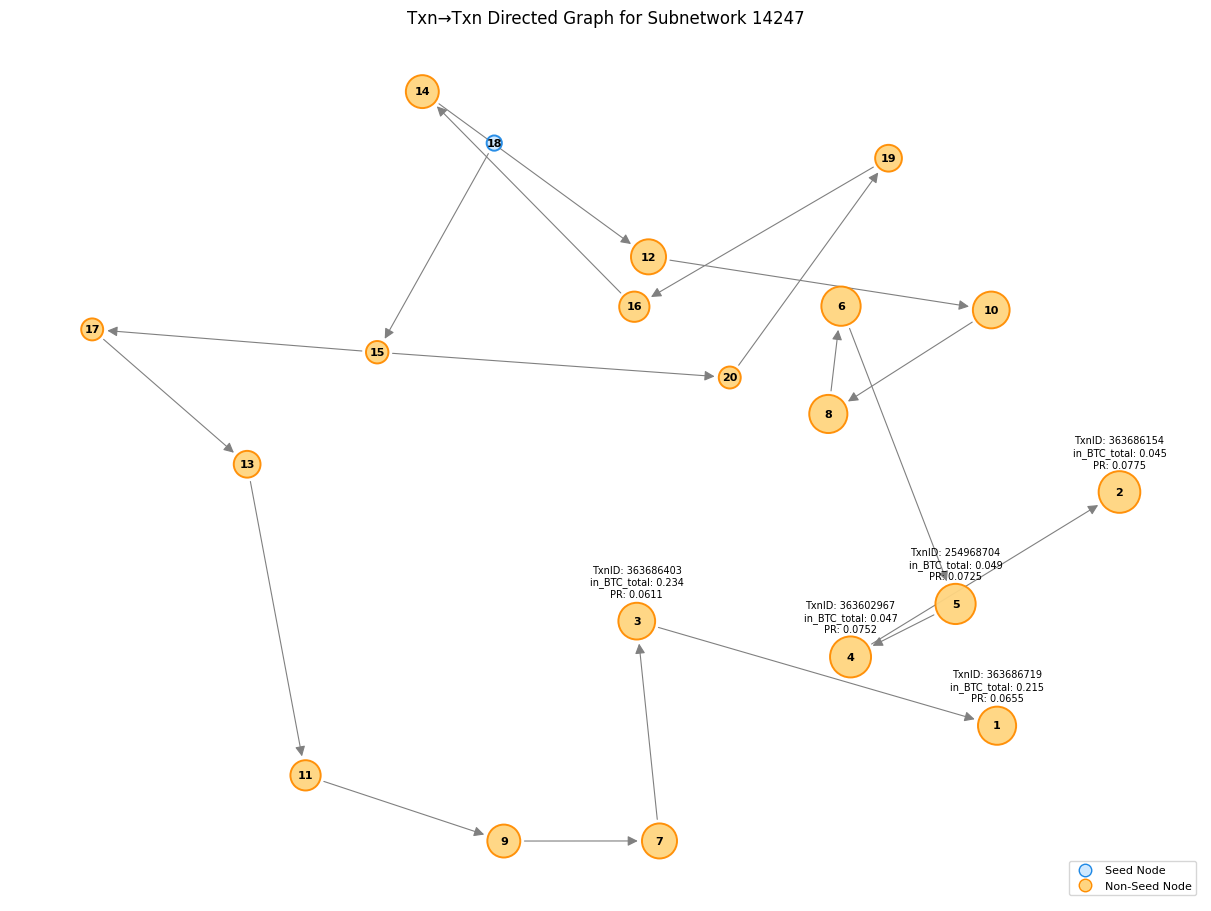

In [ ]:
G = build_vis.plot_txntxn_subnetwork(
    df_network_edges,
    df_txn_rank,
    subnetwork_id=subnetwork_filter,
    size_by="pagerank",     # ensure size is composite %
    label_by="composite_rank",   # ensure centre label is composite rank
    top_n_label=5
)


ℹ️ Converted df_rank['merged_subnetwork_id'] to int64
ℹ️ Converted df_network_edges['merged_subnetwork_id'] to int64


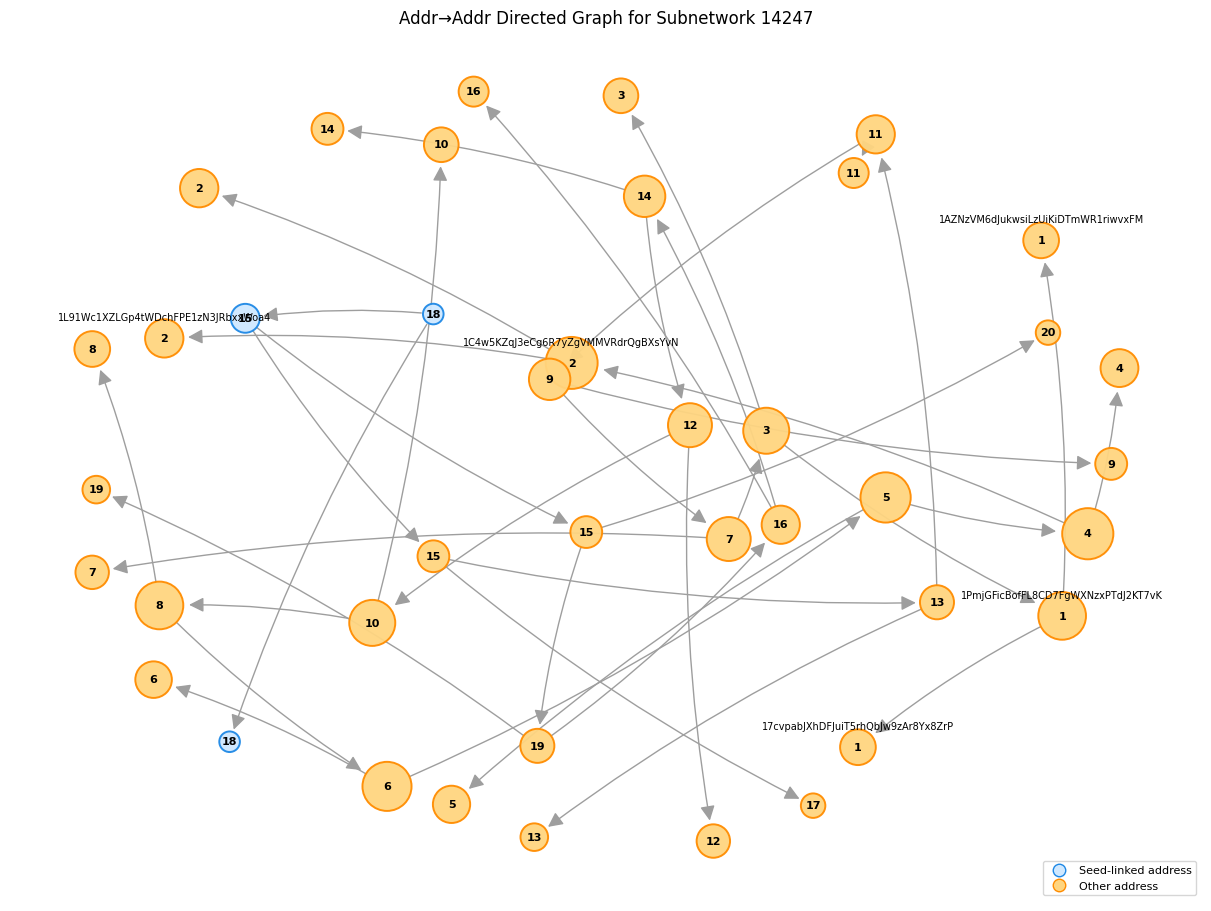

In [ ]:
G = build_vis.plot_addraddr_subnetwork(
    df_addrtxn, df_txnaddr, df_txn_rank, df_network_edges,
    merged_subnetwork_id=subnetwork_filter,
    uniform_size=False,
    others_size=100,
    top_n_label=5,
    k=1.1
)

--------------
##### Build Investigation Summary Tables

--------------

This section builds summary tables to assist investigators prioritise alerts by subnetwork.

Add in summary with count of txn per address.


In [ ]:
summary_table = build_report.build_subnetwork_viz_summary(df_txn_rank, df_addrtxn, df_txnaddr, join_to_string=True)
summary_table.head()

,subnetwork_id,txn_id,illicit_flag,seed_flag,investigation_order,in_BTC_total,composite_raw,input_addresses,output_addresses,n_inputs,n_outputs
0,0,230658142,True,False,1,3.5091,0.9869,125AS1eUZkjPNayhHEt2KLiHVzqZ5jExT1; 12ATFXLSx7...,1XFR1USgYp7gDHPhuNfqVjGF2hcKyLxo2,248,1
1,0,27405707,True,False,2,3.2574,0.9534,115Zkr1WmRWTqUoMvvMnyFVmiBcuo7b9QD; 115c96NaBJ...,3J1MmSusQRs7b4XA6hxK37t6PYK5gwf3VH,382,1
2,0,43560505,True,False,3,6.1129,0.9469,112hDfLPx3gGzUWVBmzfhNeeEtet4NW56G; 113X4nQpfK...,1KXepBmv9L2LsSxscaoi1Cr8XHazzK44T9; 36fFx8qprB...,380,2
3,0,230659438,True,False,4,0.1830,0.8423,1K8eEFjhEeh36iW7fMVZRY8Mpv1GPwkwSU,14hfBvNgqU8zBVmEUsiCj5td5QnU8eLaFA; 1FzMYbNq4D...,1,2
4,0,232377194,True,False,5,0.0416,0.7639,14MhC6hhUGePGZgNUhuk3YLtwoGZTAPRp4,1FrVYLBRPrmZ3bpeWX6SXYaY73fZpzYeM9; 1NDe8tkEPE...,1,2


END